In [12]:
import _init_paths
import nengo
import nengo_dl
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pickle

from configs.exp_configs import tf_exp_cfg as exp_cfg, nengo_dl_cfg as ngo_cfg
from utils.base_utils.data_prep_utils import get_batches_of_cifar_data
from utils.base_utils.exp_utils import collect_sim_data_spikes
from utils.nengo_dl_utils import get_nengo_dl_model
from utils.consts.dir_consts import EXP_OTPT_DIR
from utils.consts.exp_consts import SEED

In [2]:
batches = get_batches_of_cifar_data(ngo_cfg, is_test=True)
nengo_model, nengo_probes_obj_lst = get_nengo_dl_model(
    (32, 32, 3), exp_cfg, ngo_cfg)

/home/rgaurav/miniconda3/envs/nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:555: UserWarning: Activation type <function softmax at 0x2aaf2f67d680> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation


In [3]:
ndl_model_otpt = []
ndl_model_spks = []

with nengo_model.net:
  nengo_dl.configure_settings(stateful=False)

with nengo_dl.Simulator(
  nengo_model.net, minibatch_size=ngo_cfg["test_batch_size"], progress_bar=True, seed=SEED) as sim:
  nengo_input = nengo_probes_obj_lst[0]
  nengo_output = nengo_probes_obj_lst[-1]
  batch_num=1
  for batch in batches:
    sim_data = sim.predict_on_batch({nengo_input: batch[0]})
    for y_true, y_pred in zip(batch[1], sim_data[nengo_output]):
      ndl_model_otpt.append((np.argmax([y_true]), np.argmax(y_pred[-1]), y_pred))
    if batch_num == 1: # Collect only for one batch, else memory consumption is too high.
      mdl_spks = collect_sim_data_spikes(nengo_probes_obj_lst, sim_data)
      ndl_model_spks.extend(mdl_spks)
    print("Batch: %s Done." % batch_num)
    batch_num += 1
    break

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:02                                               
Batch: 1 Done.


In [4]:
print(dir(sim))

['__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_build_keras', '_call_keras', '_check_data', '_closed_attrs', '_device_context', '_generate_inputs', '_graph_context', '_keras_dtype', '_n_steps', '_standardize_data', '_time', '_update_steps', 'check_gradients', 'close', 'closed', 'compile', 'data', 'dt', 'evaluate', 'fit', 'freeze_params', 'get_name', 'get_nengo_params', 'graph', 'keras_model', 'load_params', 'loss', 'minibatch_size', 'model', 'n_steps', 'node_inputs', 'predict', 'predict_on_batch', 'progress_bar', 'reset', 'run', 'run_steps', 'save_params', 'seed', 'soft_reset', 'stateful', 'step', 'tensor_graph', 'time', 'train', 'trange', '

 ...]

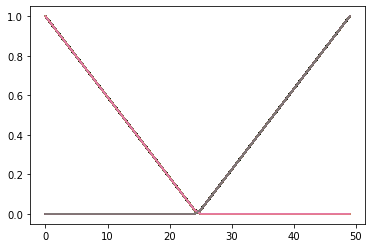

In [19]:
k = nengo.utils.ensemble.tuning_curves(list(nengo_model.layers.dict.values())[1].ensemble, sim)
k[1].shape # Tuning Curves.

In [4]:
print(sim_data.keys())

odict_keys([<Probe at 0x2ab74fca1090 of 'output' of <TensorNode "dense_2.0">>, <Probe at 0x2ab74fca13d0 of 'output' of <Neurons of <Ensemble "conv2d.0">>>, <Probe at 0x2ab7346fef90 of 'output' of <Neurons of <Ensemble "conv2d_1.0">>>, <Probe at 0x2ab734b05a90 of 'output' of <Neurons of <Ensemble "conv2d_2.0">>>, <Probe at 0x2ab74fca1350 of 'output' of <Neurons of <Ensemble "conv2d_3.0">>>, <Probe at 0x2ab74fca12d0 of 'output' of <Neurons of <Ensemble "conv2d_4.0">>>, <Probe at 0x2ab74fca1290 of 'output' of <Neurons of <Ensemble "dense.0">>>, <Probe at 0x2ab74fca11d0 of 'output' of <Neurons of <Ensemble "dense_1.0">>>])


In [7]:
conv0_p = nengo_probes_obj_lst[1]
print(sim_data[conv0_p][0][:, 6])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
print(dir(nengo_model))

['KerasTensorDict', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_layer_converters', 'allow_fallback', 'converters', 'get_converter', 'inference_only', 'inputs', 'layer_map', 'layers', 'max_to_avg_pool', 'model', 'net', 'outputs', 'register', 'scale_firing_rates', 'split_shared_weights', 'swap_activations', 'synapse', 'verify']


In [12]:
print(nengo_model.model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 96)          55392     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         110720    
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

In [18]:
print(dir(nengo_model.layers))

['__abstractmethods__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__setitem__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_get_key', 'dict', 'get', 'items', 'keys', 'values']


In [30]:
print(dir(list(nengo_model.layers.dict.values())[1].ensemble))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_initialized', '_param_init_order', '_str', 'bias', 'copy', 'dimensions', 'encoders', 'eval_points', 'gain', 'intercepts', 'label', 'max_rates', 'n_eval_points', 'n_neurons', 'neuron_type', 'neurons', 'noise', 'normalize_encoders', 'params', 'probeable', 'radius', 'seed', 'size_in', 'size_out']


In [10]:
type(list(nengo_model.layers.dict.values())[1].ensemble)

nengo.ensemble.Ensemble

In [61]:
# Print dir(sim)
#['__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', 
#'__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', 
#'__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', 
#'__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_build_keras', '_call_keras', '_check_data', 
#'_device_context', '_generate_inputs', '_graph_context', '_keras_dtype', '_n_steps', '_standardize_data', '_time', 
#'_update_steps', 'check_gradients', 'close', 'closed', 'compile', 'data', 'dt', 'evaluate', 'fit', 'freeze_params', 
#'get_name', 'get_nengo_params', 'graph', 'keras_model', 'load_params', 'loss', 'minibatch_size', 'model', 'n_steps', 
#'node_inputs', 'predict', 'predict_on_batch', 'progress_bar', 'reset', 'run', 'run_steps', 'save_params', 'seed', 
#'soft_reset', 'stateful', 'step', 'tensor_graph', 'time', 'train', 'trange', 'unroll']

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:03                                               
['__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']


In [9]:
print(dir(nengo_probes_obj_lst[1]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_initialized', '_param_init_order', '_str', 'attr', 'copy', 'label', 'obj', 'params', 'sample_every', 'seed', 'size_in', 'size_out', 'slice', 'solver', 'synapse', 'target']


In [10]:
print(dir(sim.model))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_op', 'build', 'build_callback', 'builder', 'config', 'decoder_cache', 'dt', 'fail_fast', 'has_built', 'label', 'operators', 'params', 'probes', 'seeded', 'seeds', 'sig', 'step', 'time', 'toplevel']
